# Reading the MNIST dataset and some pre-processing

In [460]:
import numpy as np
import struct

def load_mnist_images(filepath):
    with open(filepath, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, rows, cols)
    return images

def load_mnist_labels(filepath):
    with open(filepath, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

In [461]:
X_train = load_mnist_images(r"C:\Users\vardh\OneDrive\Desktop\Neural Networks\Assignment_2\train-images.idx3-ubyte")
y_train = load_mnist_labels(r"C:\Users\vardh\OneDrive\Desktop\Neural Networks\Assignment_2\train-labels.idx1-ubyte")

X_test = load_mnist_images(r"C:\Users\vardh\OneDrive\Desktop\Neural Networks\Assignment_2\t10k-images.idx3-ubyte")
y_test = load_mnist_labels(r"C:\Users\vardh\OneDrive\Desktop\Neural Networks\Assignment_2\t10k-labels.idx1-ubyte")

In [462]:
X_train.shape

(60000, 28, 28)

In [463]:
# Activation function
def sigmoid(x):
    x = np.clip(x, -50, 50)
    return 1 / (1 + np.exp(-x))

# OHE of y_train and matching the dimensions of y_train and v[-1]
def one_hot(y, num_classes=10):
    Y = np.zeros((y.shape[0], num_classes))
    Y[np.arange(y.shape[0]), y] = 1
    return Y

def softmax(x):
    x = x - np.max(x, axis=1, keepdims = True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims = True)

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return (x > 0).astype(float)

In [464]:
# converting to 2-dimension
X_train = X_train.reshape(len(X_train), -1)
X_test  = X_test.reshape(len(X_test), -1)

# normalization
X_train = X_train / 255.0
X_test  = X_test / 255.0

# X_train = X_train[:100]
# X_test = X_test[:100]
# y_train = y_train[:100]
# y_test = y_test[:100]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

y_train_ohe = one_hot(y_train)
y_test_ohe = one_hot(y_test)


(60000, 784)
(60000,)
(10000, 784)
(10000,)


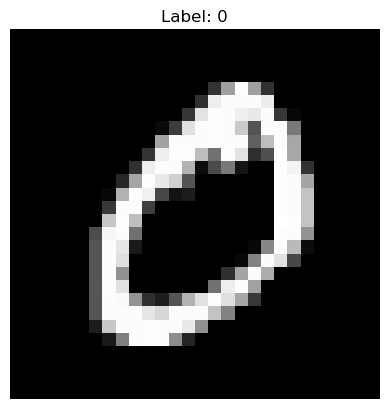

In [465]:
# plotting one image
import matplotlib.pyplot as plt

plt.imshow(X_train[1].reshape(28, 28), cmap='gray')
plt.title(f"Label: {y_train[1]}")
plt.axis('off')
plt.show()

# Setting up architecture with first forward pass

In [466]:
# So the input layer will always have 784 nodes and output layer will have 10 nodes.
# Lets make number of layers and number of nodes in each layer to be user-given

input_dim = [X_train.shape[1]]
hidden_layers = [148, 49]
output_dim = [y_train_ohe.shape[1]]

layers = input_dim + hidden_layers + output_dim   # [784, ........, 10]
print(layers)
W = []
b = []


for i in range(len(layers) - 1):
    # w = np.random.randn(layers[i], layers[i+1]) * 0.01   # too small
    w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(2 / layers[i])
    bias = np.zeros((1, layers[i+1]))

    W.append(w)
    b.append(bias)

    # print(W[i].shape)  # (784, 128), (128, 64), (64, 10)
    # print(b[i].shape)  # (1, 128), (1, 64), (1, 10)


[784, 148, 49, 10]


In [467]:
def forward_pass(X, W, b):
    u = []
    u.append(X)    # this makes u[0] = x
    v = []
    v.append(u[0])    # this makes v[0] = x
    # print(u)    
    # first forward pass
    for l in range(len(W)):
        next_u = v[l] @ W[l] + b[l]   # this calculates u[l+1]
        u.append(next_u)
        if l == L-1:
            # last layer
            next_v = softmax(next_u)  # this calculates v[-1]
        else:
            next_v = relu(next_u)  # this calculates v[l+1]
        v.append(next_v)
    
    # for i in range(len(u)):
    #     print(f"u[{i}].shape =", u[i].shape)
    #     print(f"v[{i}].shape =", v[i].shape)

    return u, v
    # y_train_ohe.shape == v[-1].shape      => true

# Backpropagation

In [468]:
def backward_pass(u, v, W, y_true):
    # for computing deltas
    L = len(W)      # number of weight layers
    delta = [None]*(L+1)
    
    # delta[L] = (v[L] - y_true) * (v[L] * (1 - v[L]))    # output delta
    delta[L] = v[-1] - y_true
    # calculating all deltas
    for l in range(L-1, 0, -1):
        # delta[l] = (delta[l+1] @ W[l].T) * (v[l] * (1 - v[l]))     # sigmoid grad
        delta[l] = (delta[l+1] @ W[l].T) * (relu_grad(u[l]))
    
    # check
    # for l in range(1, L+1):
    #     print(f"shape of delta[{l}] = {delta[l].shape}")

    return delta

def compute_gradients(v, delta, batch_size):
    L = len(delta) - 1
    # Calculating gradients
    dW = [None] * L
    db = [None] * L
    
    for l in range(L):
        dW[l] = ( v[l].T @ delta[l+1] ) / (batch_size)
        db[l] = np.mean(delta[l+1], axis = 0, keepdims=True)
        # print(dW[l].shape)
        # (784, 128), (128, 64), (64, 10)

    # for l in range(len(dW)):
    #     print(f"Layer {l} grad norm:", np.linalg.norm(dW[l]))

    return dW, db

def train_step(X_batch, y_batch, W, b, lr):
    u, v = forward_pass(X_batch, W, b)
    
    # loss = 0.5 * (np.mean((v[-1] - y_batch) ** 2))
    loss = -np.mean(np.sum(y_batch * np.log(v[-1] + 1e-8), axis=1))    # 1e-8 to avoid log(0)
    
    # backward
    delta = backward_pass(u, v, W, y_batch)

    # for l in range(len(W)):
    #     print(f"W[{l}].shape =", W[l].shape)
    #     print(f"b[{l}].shape =", b[l].shape)
    
    # gradients
    n_samples = X_batch.shape[0]
    dW, db = compute_gradients(v, delta, n_samples)

    # for l in range(len(dW)):
    #     print(f"dW[{l}].shape =", dW[l].shape)
    
    # update
    for l in range(len(W)):
        W[l] -= lr * dW[l]
        b[l] -= lr * db[l]

    return loss

In [469]:
# Epochs loop
def train_model(X, y, W, b, epochs = 10, lr = 0.01, batch_size = 128):
    losses = []
    n_samples = X.shape[0]
    for epoch in range(epochs):
        perm = np.random.permutation(n_samples)
        X_shuffled = X[perm]
        y_shuffled = y[perm]
        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i: i+batch_size]
            y_batch = y_shuffled[i: i+batch_size]
            loss = train_step(X_batch, y_batch, W, b, lr)
            losses.append(loss)

        print(f"Epoch {epoch+1}/ {epochs}, Loss = {loss: .2f}")
    return losses

In [470]:
losses = train_model(X_train, y_train_ohe, W, b, epochs=20, lr=0.01, batch_size = 1000)

# losses = train_model(X_train, y_train_ohe, W, b, epochs=20, lr=0.01, batch_size, "stochastic")
# losses = train_model(X_train, y_train_ohe, W, b, epochs=20, lr=0.01, batch_size, "batch")

Epoch 1/ 20, Loss =  1.90
Epoch 2/ 20, Loss =  1.55
Epoch 3/ 20, Loss =  1.20
Epoch 4/ 20, Loss =  0.95
Epoch 5/ 20, Loss =  0.78
Epoch 6/ 20, Loss =  0.67
Epoch 7/ 20, Loss =  0.61
Epoch 8/ 20, Loss =  0.59
Epoch 9/ 20, Loss =  0.58
Epoch 10/ 20, Loss =  0.49
Epoch 11/ 20, Loss =  0.49
Epoch 12/ 20, Loss =  0.47
Epoch 13/ 20, Loss =  0.41
Epoch 14/ 20, Loss =  0.44
Epoch 15/ 20, Loss =  0.42
Epoch 16/ 20, Loss =  0.40
Epoch 17/ 20, Loss =  0.37
Epoch 18/ 20, Loss =  0.35
Epoch 19/ 20, Loss =  0.35
Epoch 20/ 20, Loss =  0.35


# Testing phase and visualizations

In [471]:
def forward_pass(X, W, b):
    u = {}
    v = {}

    v[0] = X
    u[0] = X

    L = len(W)

    for l in range(1, L):
        u[l] = v[l-1] @ W[l-1] + b[l-1]
        v[l] = relu(u[l])

    # output layer
    u[L] = v[L-1] @ W[L-1] + b[L-1]
    v[L] = softmax(u[L])

    return v[L]

y_val = forward_pass(X_train, W, b)
y_val_labels = np.argmax(y_val, axis=1)
train_acc = np.mean(y_val_labels == y_train)
print(f"Training accuracy: {train_acc* 100: 0.02f}%")

y_pred = forward_pass(X_test, W, b)
y_pred_labels = np.argmax(y_pred, axis=1)
test_acc = np.mean(y_pred_labels == y_test)
print(f"Testing accuracy: {test_acc* 100: 0.02f}%")

Training accuracy:  89.67%
Testing accuracy:  90.45%


In [472]:
def confusion_matrix(y_true, y_pred, num_classes=10):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def classification_metrics(cm):
    num_classes = cm.shape[0]

    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    support = np.sum(cm, axis=1)  # true count per class

    for k in range(num_classes):
        TP = cm[k, k]
        FP = np.sum(cm[:, k]) - TP
        FN = np.sum(cm[k, :]) - TP

        precision[k] = TP / (TP + FP + 1e-9)
        recall[k]    = TP / (TP + FN + 1e-9)
        f1[k]        = 2 * precision[k] * recall[k] / (precision[k] + recall[k] + 1e-9)

    return precision, recall, f1, support

def evaluate_model(X, y_true, W, b, num_classes=10):
    y_pred_prob = forward_pass(X, W, b)
    y_pred = np.argmax(y_pred_prob, axis=1)

    cm = confusion_matrix(y_true, y_pred, num_classes)
    precision, recall, f1, support = classification_metrics(cm)

    accuracy = np.mean(y_pred == y_true)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "macro_f1": np.mean(f1),
        "weighted_f1": np.sum((support / np.sum(support)) * f1),
        "confusion_matrix": cm
    }

test_metrics  = evaluate_model(X_test, y_test, W, b)

In [473]:
def print_metrics(metrics, num_classes=10, title="Model Evaluation"):
    print("\n" + "="*50)
    print(title)
    print("="*50)

    # Overall metrics
    print(f"Accuracy       : {metrics['accuracy']:.4f}")
    print(f"Macro F1       : {metrics['macro_f1']:.4f}")
    print(f"Weighted F1    : {metrics['weighted_f1']:.4f}")

    print("\nPer-class metrics:")
    print(f"{'Class':<8}{'Precision':<12}{'Recall':<12}{'F1':<12}{'Support'}")

    precision = metrics['precision']
    recall = metrics['recall']
    f1 = metrics['f1']
    cm = metrics['confusion_matrix']
    support = np.sum(cm, axis=1)

    for i in range(num_classes):
        print(f"{i:<8}"
              f"{precision[i]:<12.2f}"
              f"{recall[i]:<12.2f}"
              f"{f1[i]:<12.2f}"
              f"{support[i]}")

    # print("\nConfusion Matrix:")
    # print(cm)
    # print("="*50)

    return cm

cm = print_metrics(test_metrics, num_classes=10, title="TEST SET METRICS")


TEST SET METRICS
Accuracy       : 0.9045
Macro F1       : 0.9029
Weighted F1    : 0.9041

Per-class metrics:
Class   Precision   Recall      F1          Support
0       0.93        0.98        0.95        980
1       0.96        0.97        0.96        1135
2       0.91        0.87        0.89        1032
3       0.88        0.89        0.88        1010
4       0.89        0.93        0.91        982
5       0.88        0.83        0.85        892
6       0.92        0.93        0.92        958
7       0.93        0.91        0.92        1028
8       0.86        0.85        0.86        974
9       0.89        0.88        0.88        1009


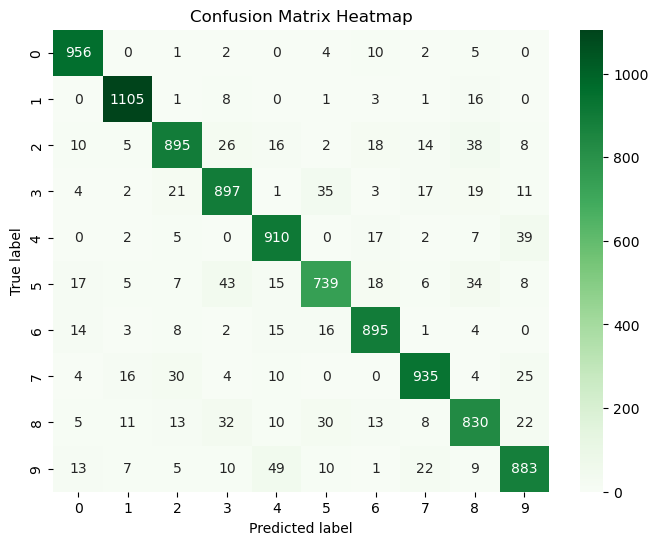

In [474]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix Heatmap")
plt.show()

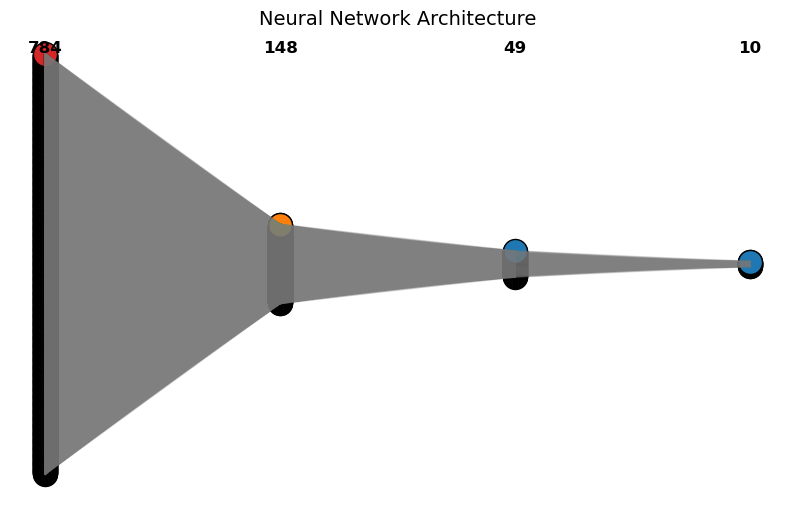

In [475]:
import matplotlib.pyplot as plt

def plot_nn_architecture(layers):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis("off")

    layer_x = range(len(layers))
    max_neurons = max(layers)

    for i, neurons in enumerate(layers):
        # y positions (centered)
        y_positions = [
            j - neurons / 2 for j in range(neurons)
        ]

        # plot neurons
        for y in y_positions:
            ax.scatter(layer_x[i], y, s=300, edgecolors="black")

        # plot connections
        if i > 0:
            prev_neurons = layers[i - 1]
            prev_y = [j - prev_neurons / 2 for j in range(prev_neurons)]

            for y1 in prev_y:
                for y2 in y_positions:
                    ax.plot(
                        [layer_x[i - 1], layer_x[i]],
                        [y1, y2],
                        color="gray",
                        alpha=0.05
                    )

        # layer label
        ax.text(
            layer_x[i],
            max_neurons / 2 + 1,
            f"{neurons}",
            ha="center",
            fontsize=12,
            fontweight="bold"
        )

    ax.set_title("Neural Network Architecture", fontsize=14)
    plt.show()

plot_nn_architecture(layers)